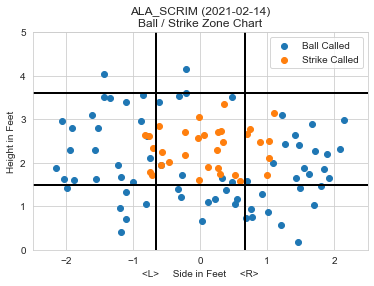

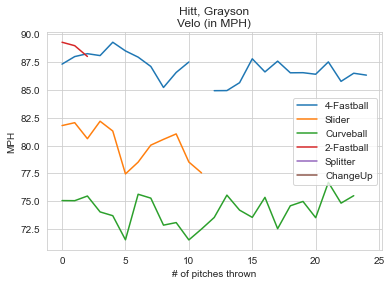

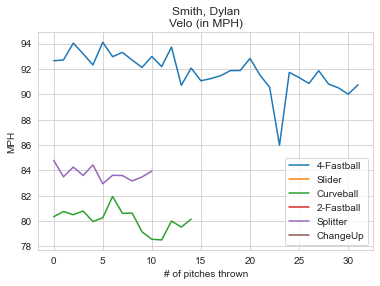

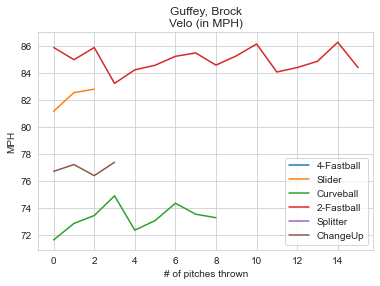

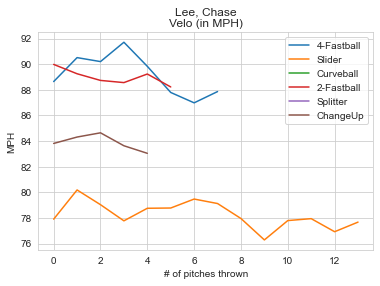

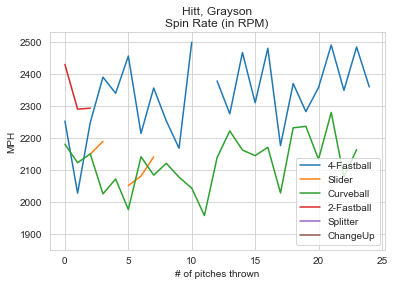

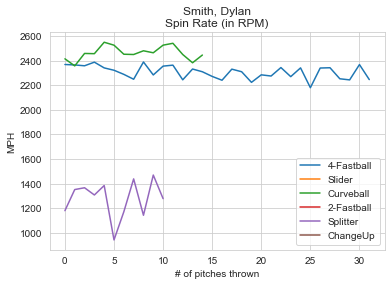

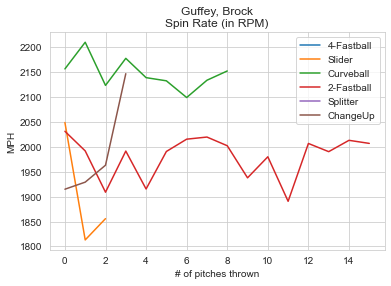

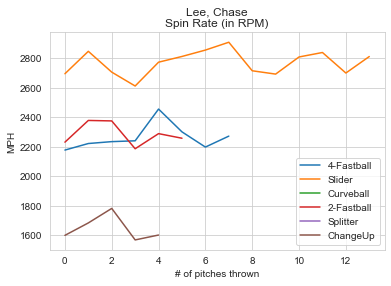

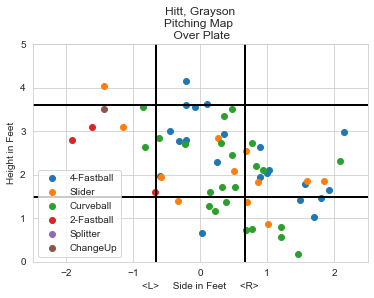

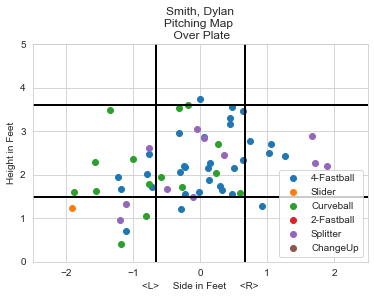

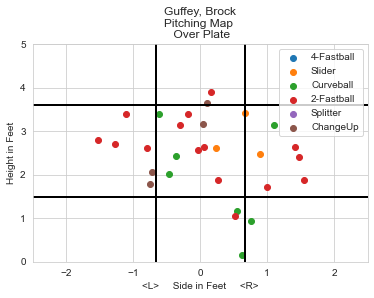

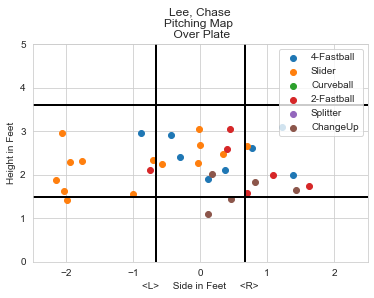

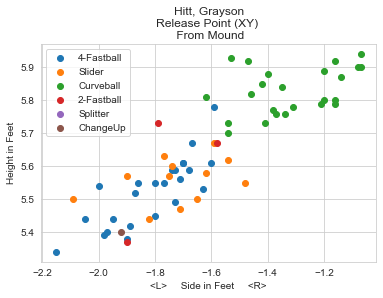

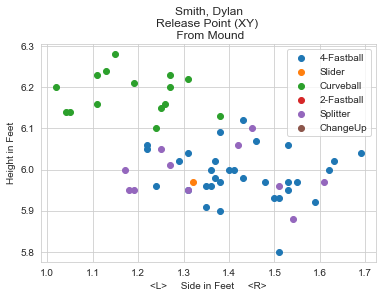

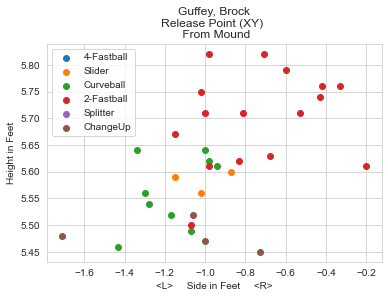

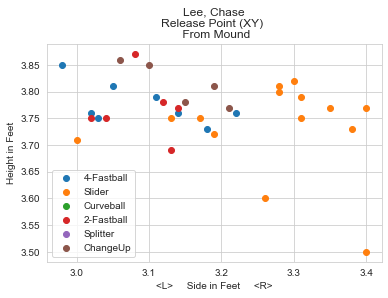

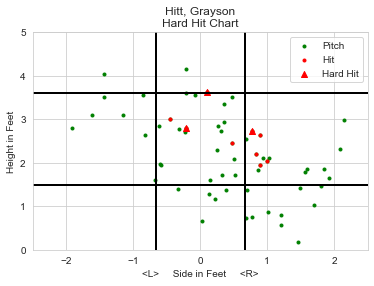

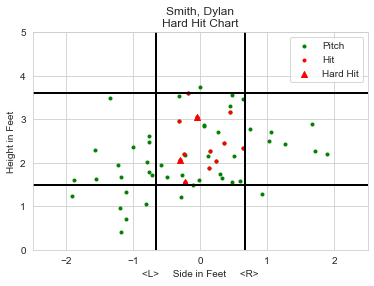

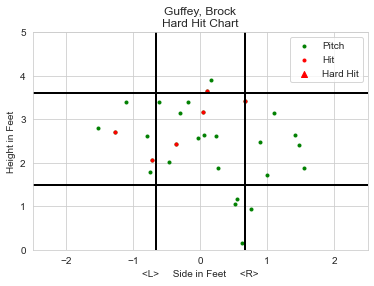

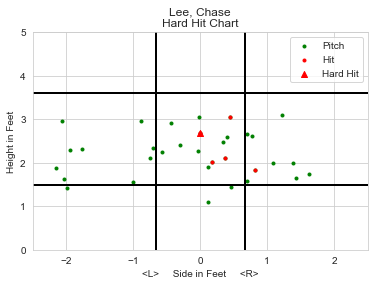

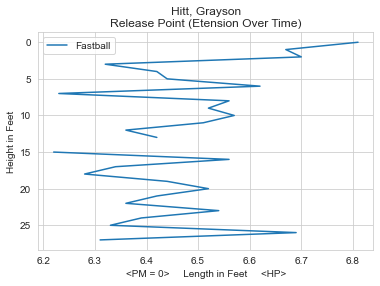

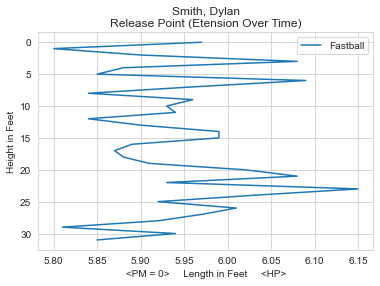

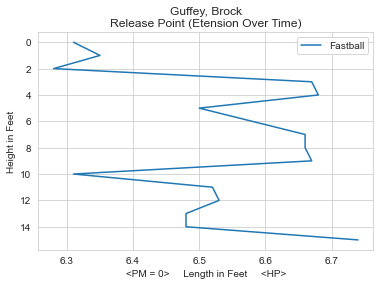

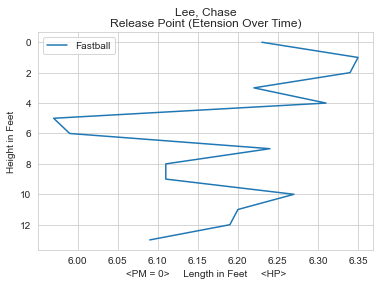

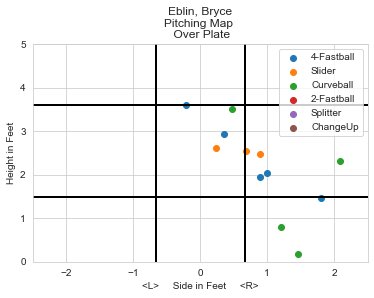

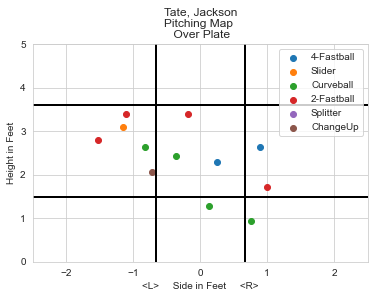

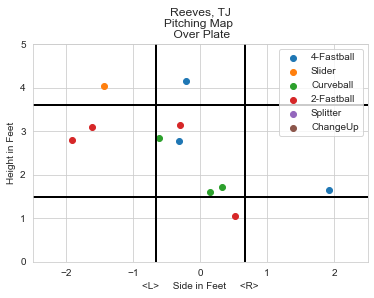

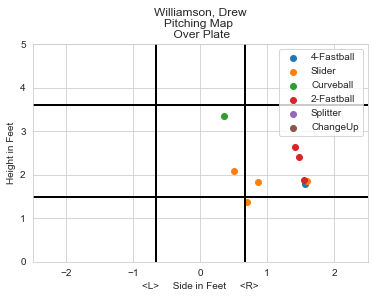

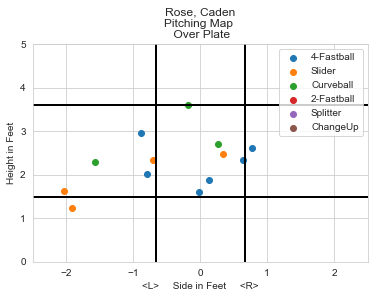

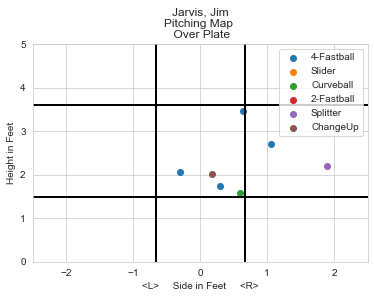

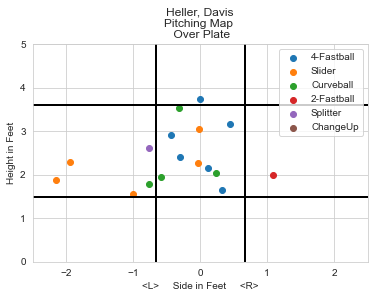

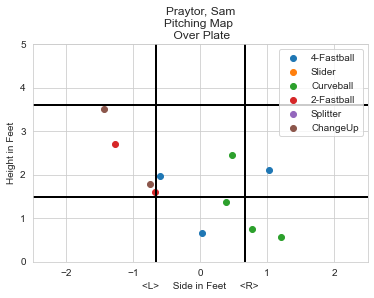

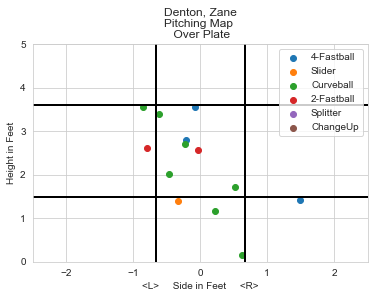

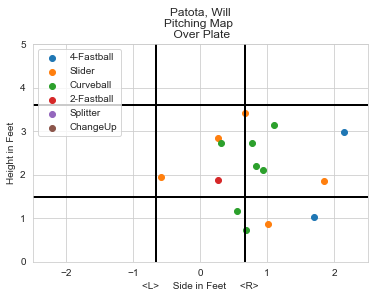

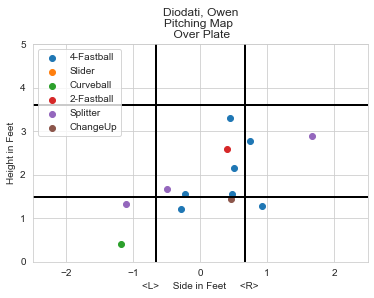

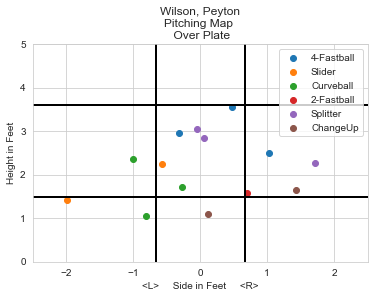

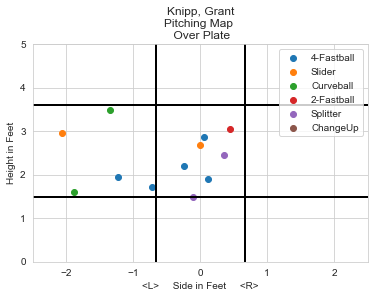

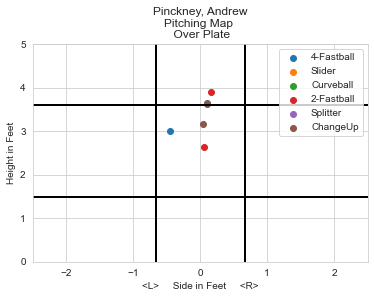

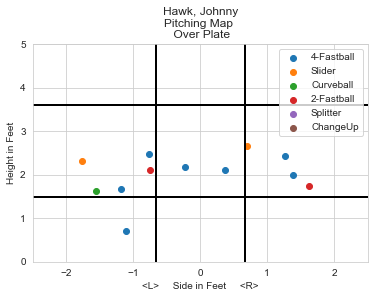

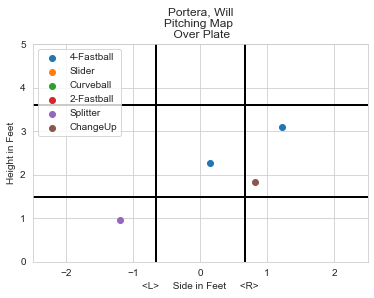

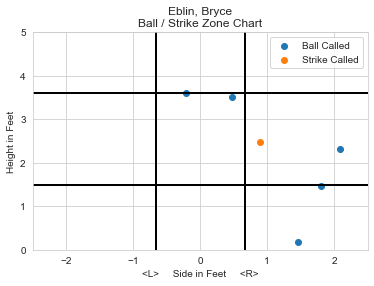

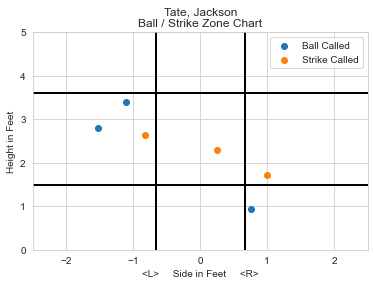

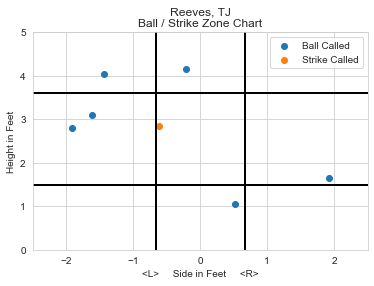

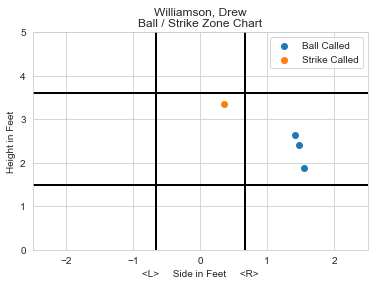

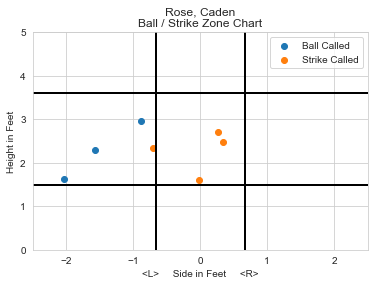

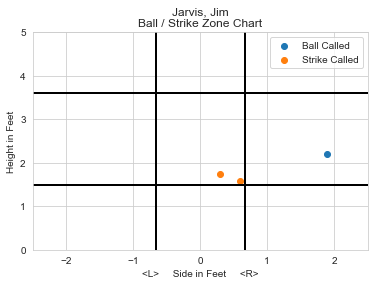

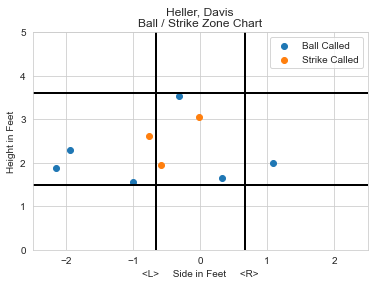

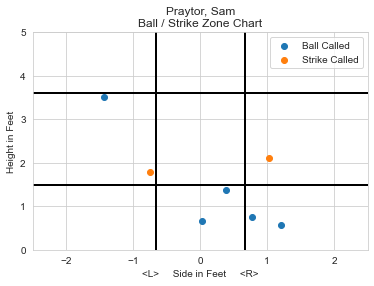

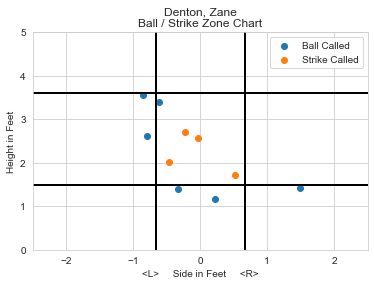

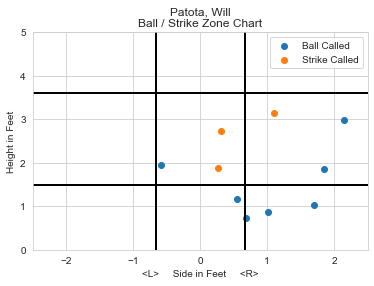

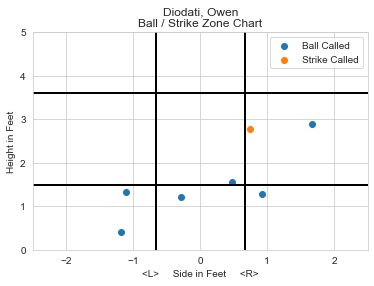

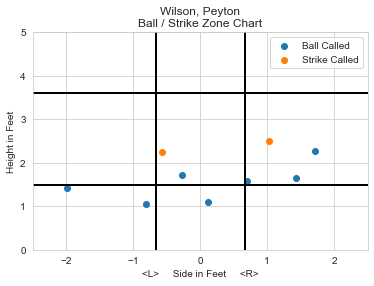

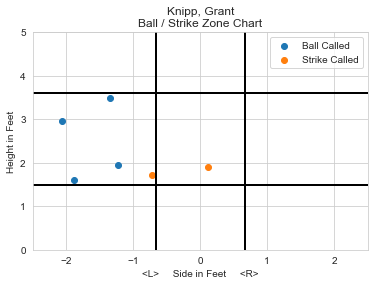

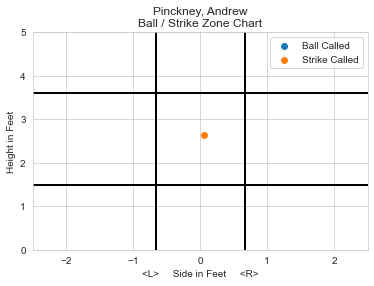

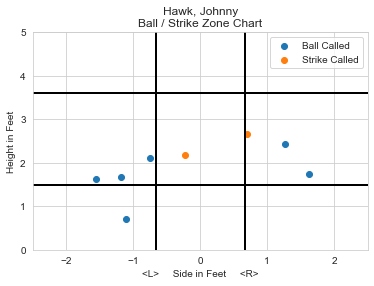

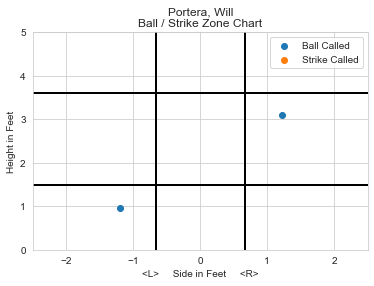

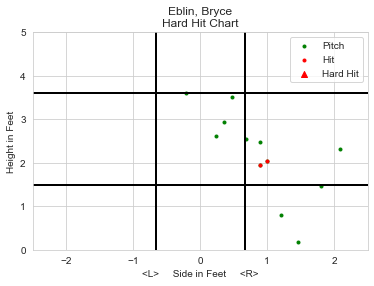

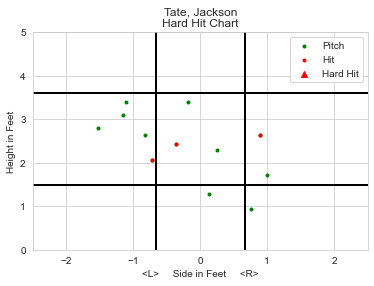

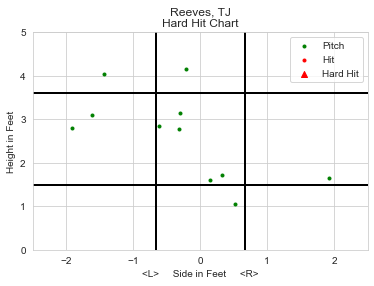

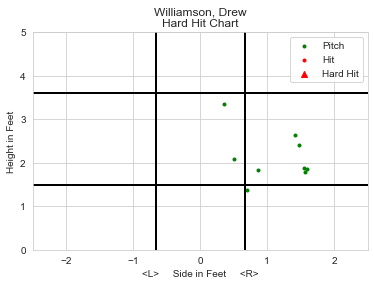

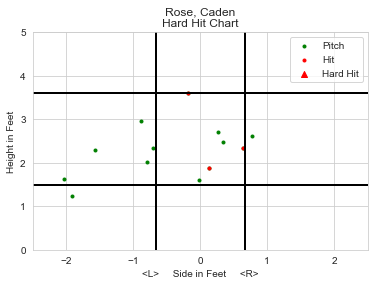

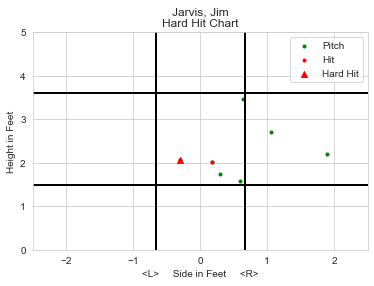

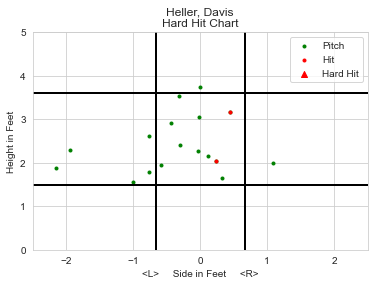

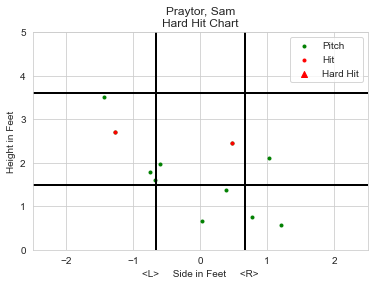

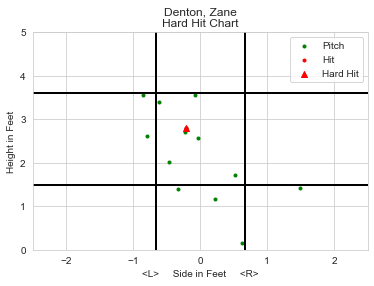

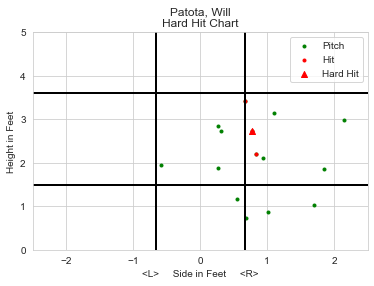

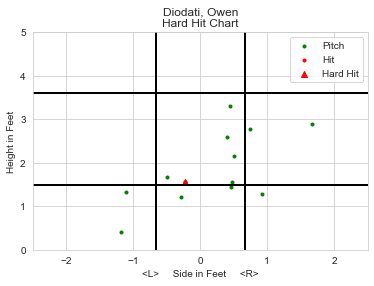

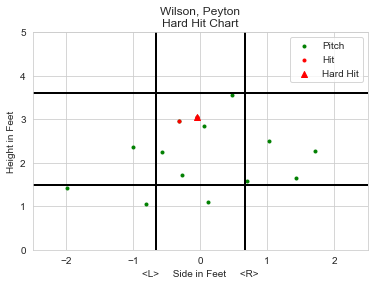

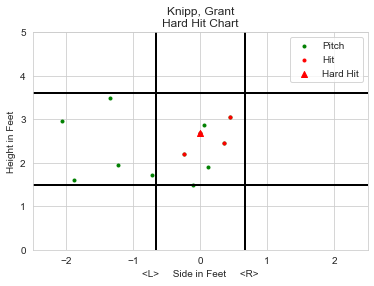

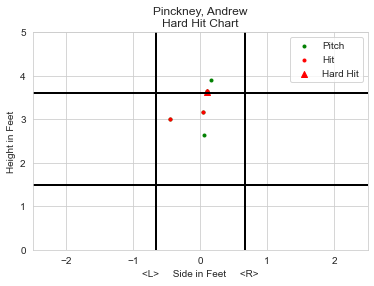

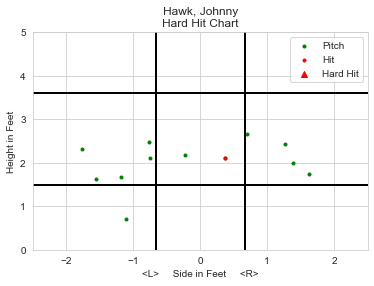

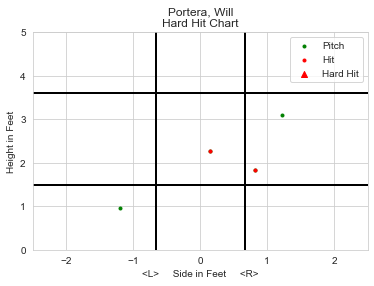

In [6]:
def postgame_report(data='Raw', path='C:\\Users\\bmmcc\\OneDrive\\Desktop\\2021 Regular Season\\'):
    # ---------- Import Libraries ----------
    import os
    import csv
    import datetime
    import shutil
    import pdfkit
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from PyPDF2 import PdfFileMerger
    sns.set_style('whitegrid')

    # ---------- Import CSV and Clean ----------
    df = pd.read_csv(data + '.csv').replace(0, np.nan).round(2)
    df = df[df['TaggedPitchType'] != 'Undefined']
    df['TaggedPitchType'] = df['TaggedPitchType'].replace(['Fastball'],'4-Fastball')
    df['TaggedPitchType'] = df['TaggedPitchType'].replace(['Sinker'],'2-Fastball')
    df['HardHit'] = pd.cut(df['ExitSpeed'],bins=[0,95,2000], labels=[0,1]).astype(str)

    # ---------- Convert to scrimmage code (if needed) -----------
    if df['BatterTeam'][0] == 'ALA_CRI1': 
        df['BatterTeam'] = df['BatterTeam'].replace(['ALA_CRI1'],'ALA_SCRIM')
        df['PitcherTeam'] = df['PitcherTeam'].replace(['ALA_CRI1'],'ALA_SCRIM')
    else: pass

    # ---------- Create Game ID and Game Folder ---------
    game_id = str(df['BatterTeam'].reset_index(drop = True)[0]) + ' (' + str(pd.to_datetime(df['Date'][0]).date()) + ')'
    shutil.copytree('Game_Summary - Temp', game_id)

    # ---------- PDF endings ----------
    pdf_endings_pitching = ['a.pdf', 'b.pdf', 'c.pdf', 'd.pdf', 'e.pdf', 'f.pdf']
    pdf_endings_hitting = ['a.pdf', 'b.pdf', 'c.pdf']

    # ---------- Create Alabama and Opponent Dataframes -----------
    df_opponent = df[df['PitcherTeam'].str.contains('ALA_CRI') == False]
    df_pitches = df['TaggedPitchType'].unique().tolist()

    # ---------- Pitcher / Hitter indexs (scrimmages or games)] --------
    if df['BatterTeam'][0] == 'ALA_SCRIM': 
        df_alabama = df
    else:
        df_alabama = df[df['PitcherTeam'].str.contains('ALA_CRI')]

    if df['BatterTeam'][0] == 'ALA_SCRIM': 
        df_opponent = df
    else:
        df_opponent = df[df['PitcherTeam'].str.contains('ALA_CRI') == False] 

    if df['BatterTeam'][0] == 'ALA_SCRIM': 
        df_alabama_hitter_index = df['Batter'].unique().tolist()
    else: 
        df_alabama_hitter_index = df_alabama['Batter'].unique().tolist()
        df_opponent_hitter_index = df_opponent['Batter'].unique().tolist()

    if df['BatterTeam'][0] == 'ALA_SCRIM': 
        df_alabama_pitchers_index = df['Pitcher'].unique().tolist()
    else:
        df_alabama_pitchers_index = df_alabama['Pitcher'].unique().tolist()
        df_opp_pitchers_index = df_opponent['Pitcher'].unique().tolist() 

    # ---------- Create summary reports and send to CSV File---------
    df_alabama_pitches = df_alabama.groupby(['Pitcher', 'TaggedPitchType'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'RelHeight', 'RelSide', 'Extension', 'pfxx', 'pfxz']].mean()
    df_opponent_pitches = df_opponent.groupby(['Pitcher', 'TaggedPitchType'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'RelHeight', 'RelSide', 'Extension', 'pfxx', 'pfxz']].mean()
    df_alabama_hitting = df_opponent.groupby(['Batter', 'TaggedPitchType'])[['ExitSpeed', 'Angle', 'Direction', 'HitSpinRate', 'Distance', 'HangTime']].mean()
    df_opponent_hitting = df_alabama.groupby(['Batter', 'TaggedPitchType'])[['ExitSpeed', 'Angle', 'Direction', 'HitSpinRate', 'Distance', 'HangTime']].mean()

    df_alabama_pitches.to_csv(game_id + '\\Pitching\\Summary\\ ' + game_id + ' -- Alabama Pitching Summary.csv')
    df_opponent_pitches.to_csv(game_id + '\\Hitting\\Summary\\' + game_id + ' -- Opponent Pitching Summary.csv')
    df_opponent_hitting.to_csv(game_id + '\\Pitching\\Summary\\' + game_id + ' -- Opponent Batting Summary.csv')
    df_alabama_hitting.to_csv(game_id + '\\Hitting\\Summary\\' + game_id + ' -- Alabama Batting Summary.csv')

    # ---------- Individual Reports --------- 
    name_count = 1
    for name in df_alabama_pitchers_index:
        inv_pitch = df_alabama[df_alabama['Pitcher'].str.contains(name)]
        df_alabama_pitches = inv_pitch.groupby(['TaggedPitchType'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'RelSide', 'RelHeight', 'Extension', 'pfxx', 'pfxz']].mean()
        df_alabama_pitches.to_csv(game_id + '\\Pitching\\pitcher_' + str(name_count) + '//' + name + ' Summary.csv')
        os.rename(game_id + '\\Pitching\\pitcher_' + str(name_count), game_id + '\\Pitching\\' + name)    
        name_count += 1

    name_count = 1
    for name in df_alabama_hitter_index:
        os.rename(game_id + '\\Hitting\\batter_' + str(name_count), game_id + '\\Hitting\\' + name)    
        name_count += 1

    # ---------- Strike Zone Report ---------
    frame = df[['PlateLocHeight', 'PlateLocSide', 'PitchCall']]
    df_ball = frame[frame['PitchCall'].str.contains('BallCalled')]
    df_strike = frame[frame['PitchCall'].str.contains('StrikeCalled')]
    plt.scatter(df_ball['PlateLocSide'], df_ball['PlateLocHeight'], label='Ball Called')
    plt.scatter(df_strike['PlateLocSide'], df_strike['PlateLocHeight'], label='Strike Called')
    plt.axhline(y=1.5, linewidth=2, color='k')
    plt.axhline(y=3.6, linewidth=2, color='k')
    plt.axvline(x=(2/3), linewidth=2, color='k')
    plt.axvline(x=(-2/3), linewidth=2, color='k')
    plt.legend()
    plt.title(game_id + '\nBall / Strike Zone Chart')
    plt.xlabel('<L>     Side in Feet     <R>')
    plt.ylabel('Height in Feet')
    plt.xlim([-2.5, 2.5])
    plt.ylim([0, 5]) 
    plt.savefig(game_id + '//Game//' + game_id + ' - Stike Zone.pdf')
    plt.show()

    # ---------- Velo Trend Report ---------
    for name in df_alabama_pitchers_index:
        for pitch in df_pitches:
            df_pitch_spec_name = df[df['Pitcher'].str.contains(name)]
            df_pitch_spec_pitch = df_pitch_spec_name[df_pitch_spec_name['TaggedPitchType'].str.contains(pitch)]
            df_pitch_spec = df_pitch_spec_pitch['RelSpeed']
            df_pitch_spec = df_pitch_spec.reset_index()
            df_pitch_spec = df_pitch_spec.drop(['index'], axis=1)
            plt.plot(df_pitch_spec, label = pitch)
            plt.xlabel('# of pitches thrown')
            plt.ylabel('MPH')
            plt.title(name + '\nVelo (in MPH)')
            plt.legend()
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[0], bbox_inches='tight')
        plt.show()

    # ---------- SpinRate Trend Report ---------
    for name in df_alabama_pitchers_index:
        for pitch in df_pitches:
            df_pitch_spec_name = df[df['Pitcher'].str.contains(name)]
            df_pitch_spec_pitch = df_pitch_spec_name[df_pitch_spec_name['TaggedPitchType'].str.contains(pitch)]
            df_pitch_spec = df_pitch_spec_pitch['SpinRate']
            df_pitch_spec = df_pitch_spec.reset_index()
            df_pitch_spec = df_pitch_spec.drop(['index'], axis=1)
            plt.plot(df_pitch_spec, label = pitch)
            plt.xlabel('# of pitches thrown')
            plt.ylabel('MPH')
            plt.title(name + '\nSpin Rate (in RPM)')
            plt.legend()
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[1], bbox_inches='tight')
        plt.show()

    # ---------- Pitches by type by player Report ---------
    for name in df_alabama_pitchers_index:
        for pitch in df_pitches:
            df_pitch_spec_name = df[df['Pitcher'].str.contains(name)]
            frame = df_pitch_spec_name[['PlateLocHeight', 'PlateLocSide', 'TaggedPitchType']]
            df_pitch_spec_name = frame[frame['TaggedPitchType'].str.contains(pitch)]    
            plt.scatter(df_pitch_spec_name['PlateLocSide'], df_pitch_spec_name['PlateLocHeight'], label=pitch)
            plt.axhline(y=1.5, linewidth=2, color='k')
            plt.axhline(y=3.6, linewidth=2, color='k')
            plt.axvline(x=(2/3), linewidth=2, color='k')
            plt.axvline(x=(-2/3), linewidth=2, color='k')
            plt.title(name + '\nPitching Map \n Over Plate')
            plt.xlabel('<L>     Side in Feet     <R>')
            plt.ylabel('Height in Feet')
            plt.legend()
            plt.xlim([-2.5, 2.5])
            plt.ylim([0, 5])      
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[2], bbox_inches='tight')
        plt.show() 

    # ---------- Release Point Report (XY) ---------
    for name in df_alabama_pitchers_index:
        for pitch in df_pitches:
            rel_name = df[df['Pitcher'].str.contains(name)]
            rel_pitch = rel_name[rel_name['TaggedPitchType'].str.contains(pitch)]
            rel_data = rel_pitch.reset_index()
            rel_data_spec = rel_data.drop(['index'], axis=1)
            plt.scatter(rel_data_spec['RelSide'], rel_data_spec['RelHeight'], label=pitch)
            plt.xlabel('<L>     Side in Feet     <R>')
            plt.ylabel('Height in Feet')
            plt.title(name + '\nRelease Point (XY) \n From Mound')
            plt.legend()
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[3], bbox_inches='tight')
        plt.show()

    # ---------- Hard Hit Report ---------
    for name in df_alabama_pitchers_index:
        pitcher_df = df[df['Pitcher'].str.contains(name)]
        hard_hit_df = pitcher_df[pitcher_df['HardHit'].str.contains('1')]
        not_hard_hit_df = pitcher_df[pitcher_df['HardHit'].str.contains('0')]
        plt.scatter(pitcher_df['PlateLocSide'], pitcher_df['PlateLocHeight'], marker='.', label='Pitch', c='g')
        plt.scatter(not_hard_hit_df['PlateLocSide'], not_hard_hit_df['PlateLocHeight'], marker='.', label='Hit', c='r')
        plt.scatter(hard_hit_df['PlateLocSide'], hard_hit_df['PlateLocHeight'], marker='^', label='Hard Hit', c='r')
        plt.axhline(y=1.5, linewidth=2, color='k')
        plt.axhline(y=3.6, linewidth=2, color='k')
        plt.axvline(x=(2/3), linewidth=2, color='k')
        plt.axvline(x=(-2/3), linewidth=2, color='k')
        plt.title(name + '\nHard Hit Chart')
        plt.xlabel('<L>     Side in Feet     <R>')
        plt.ylabel('Height in Feet')
        plt.xlim([-2.5, 2.5])
        plt.ylim([0, 5])
        plt.legend()
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[4], bbox_inches='tight')
        plt.show()

    # ---------- Release Point Report (Z) ---------
    for name in df_alabama_pitchers_index:
        rel_name = df[df['Pitcher'].str.contains(name)]
        rel_pitch = rel_name[rel_name['TaggedPitchType'].str.contains('Fastball')]
        rel_data = rel_pitch.reset_index()
        rel_data = rel_data.reset_index()
        rel_data_spec = rel_data.drop(['index'], axis=1)
        plt.plot(rel_data_spec['Extension'], rel_data_spec['level_0'], label='Fastball')
        plt.title(name + '\nRelease Point (Etension Over Time)')
        plt.xlabel('<PM = 0>     Length in Feet     <HP>')
        plt.ylabel('Height in Feet')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.savefig(game_id + '\\Pitching\\' + name + '\\' + name + pdf_endings_pitching[5], bbox_inches='tight')
        plt.show()

    # ----------- Batting Pitch Type (XY) ------------   
    for batter in df_alabama_hitter_index:
        for pitch in df_pitches:
            hitter_df = df[df['Batter'].str.contains(batter)]
            frame = hitter_df[['PlateLocHeight', 'PlateLocSide', 'TaggedPitchType']]
            df_pitch_spec_name = frame[frame['TaggedPitchType'].str.contains(pitch)]    
            plt.scatter(df_pitch_spec_name['PlateLocSide'], df_pitch_spec_name['PlateLocHeight'], label=pitch)
            plt.axhline(y=1.5, linewidth=2, color='k')
            plt.axhline(y=3.6, linewidth=2, color='k')
            plt.axvline(x=(2/3), linewidth=2, color='k')
            plt.axvline(x=(-2/3), linewidth=2, color='k')
            plt.title(batter + '\nPitching Map \n Over Plate')
            plt.xlabel('<L>     Side in Feet     <R>')
            plt.ylabel('Height in Feet')
            plt.legend()
            plt.xlim([-2.5, 2.5])
            plt.ylim([0, 5])
        plt.savefig(game_id + '\\Hitting\\' + batter + '\\' + batter + pdf_endings_hitting[0], bbox_inches='tight')
        plt.show() 

    # ---------- Strike Zone Report ---------
    for batter in df_alabama_hitter_index:
        frame = df[df['Batter'].str.contains(batter)]
        frame = frame[['PlateLocHeight', 'PlateLocSide', 'PitchCall']]
        df_ball = frame[frame['PitchCall'].str.contains('BallCalled')]
        df_strike = frame[frame['PitchCall'].str.contains('StrikeCalled')]
        plt.scatter(df_ball['PlateLocSide'], df_ball['PlateLocHeight'], label='Ball Called')
        plt.scatter(df_strike['PlateLocSide'], df_strike['PlateLocHeight'], label='Strike Called')
        plt.axhline(y=1.5, linewidth=2, color='k')
        plt.axhline(y=3.6, linewidth=2, color='k')
        plt.axvline(x=(2/3), linewidth=2, color='k')
        plt.axvline(x=(-2/3), linewidth=2, color='k')
        plt.legend()
        plt.title(batter + '\nBall / Strike Zone Chart')
        plt.xlabel('<L>     Side in Feet     <R>')
        plt.ylabel('Height in Feet')
        plt.xlim([-2.5, 2.5])
        plt.ylim([0, 5]) 
        plt.savefig(game_id + '\\Hitting\\' + batter + '\\' + batter + pdf_endings_hitting[1], bbox_inches='tight')
        plt.show()

    # ---------- Hard Hit Report ---------
    for batter in df_alabama_hitter_index:
        batter_df = df[df['Batter'].str.contains(batter)]
        hard_hit_df = batter_df[batter_df['HardHit'].str.contains('1')]
        not_hard_hit_df = batter_df[batter_df['HardHit'].str.contains('0')]
        plt.scatter(batter_df['PlateLocSide'], batter_df['PlateLocHeight'], marker='.', label='Pitch', c='g')
        plt.scatter(not_hard_hit_df['PlateLocSide'], not_hard_hit_df['PlateLocHeight'], marker='.', label='Hit', c='r')
        plt.scatter(hard_hit_df['PlateLocSide'], hard_hit_df['PlateLocHeight'], marker='^', label='Hard Hit', c='r')
        plt.axhline(y=1.5, linewidth=2, color='k')
        plt.axhline(y=3.6, linewidth=2, color='k')
        plt.axvline(x=(2/3), linewidth=2, color='k')
        plt.axvline(x=(-2/3), linewidth=2, color='k')
        plt.title(batter + '\nHard Hit Chart')
        plt.xlabel('<L>     Side in Feet     <R>')
        plt.ylabel('Height in Feet')
        plt.xlim([-2.5, 2.5])
        plt.ylim([0, 5])
        plt.legend()
        plt.savefig(game_id + '\\Hitting\\' + batter + '\\' + batter + pdf_endings_hitting[2], bbox_inches='tight')
        plt.show()    

    # ---------- Merge and Delete the Pitching PDF Files ------------- 
    for name in df_alabama_pitchers_index:
        merger = PdfFileMerger()
        for pdf_ending in pdf_endings_pitching:
            pdf_name = game_id + '\\Pitching\\' + name + '\\' + name + pdf_ending
            merger.append(pdf_name)
        merger.write(game_id + '\\Pitching\\' + name + '\\' + name + " result.pdf")
        merger.close()

    for name in df_alabama_pitchers_index:
        for pdf_ending in pdf_endings_pitching:
            pdf_name = game_id + '\\Pitching\\' + name + '\\' + name + pdf_ending    
            os.remove(pdf_name)

    # ---------- Merge and Delete the Hitting PDF Files ------------- 
    for name in df_alabama_hitter_index:
        merger = PdfFileMerger()
        for pdf_ending in pdf_endings_hitting:
            pdf_name = game_id + '\\Hitting\\' + name + '\\' + name + pdf_ending
            merger.append(pdf_name)
        merger.write(game_id + '\\Hitting\\' + name + '\\' + name + " result.pdf")
        merger.close()

    for name in df_alabama_hitter_index:
        for pdf_ending in pdf_endings_hitting:
            pdf_name = game_id + '\\Hitting\\' + name + '\\' + name + pdf_ending    
            os.remove(pdf_name)

    # ---------- Save then Delete Raw CSV to records as game_id --------------
    df.set_index('PitchNo', inplace=True)
    df.to_csv(game_id + '\\Game\\' + game_id + ' - Data.csv')
    df.to_csv('Archived Data\\' + game_id + ' - Data.csv')

    # ---------- Delete Extra Files ---------
    count = 0
    while count <= 20: 
        count += 1
        try: shutil.rmtree(game_id + '\\Pitching\\pitcher_' + str(count))
        except: pass
        try: shutil.rmtree(game_id + '\\Hitting\\batter_' + str(count))
        except: pass

    # --------- Manage Files ---------
    shutil.make_archive(path + game_id, 'zip', game_id)
    shutil.rmtree(game_id)
    #os.remove('Raw.csv')

# --------- Run the Function --------
postgame_report()